In [47]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import metrics

df = pd.read_csv('Price_euros_train.csv',encoding='ISO-8859-1')
test_data = pd.read_csv('Price_euros_test.csv',encoding='ISO-8859-1')
df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
3,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1315,Asus,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,4GB,500GB HDD,Nvidia GeForce 920M,Windows 10,2.2kg,720.32
1104,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1105,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1106,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [48]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
3,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97


In [49]:
df_nan = df.loc[:, df.isnull().any()]
df_nan.isnull().sum() / len(df_nan) * 100

ScreenResolution    0.992780
OpSys               4.783394
Weight              1.985560
dtype: float64

In [50]:
df['OpSys'].unique()

array(['macOS', 'Windows 10', 'Mac OS X', 'No OS', nan, 'Linux',
       'Android', 'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

In [51]:
df.groupby('Company')['OpSys'].apply(lambda x: x.isnull().sum())

Company
Acer          3
Apple         2
Asus          6
Chuwi         0
Dell         12
Fujitsu       0
Google        0
HP           10
LG            0
Lenovo       17
MSI           2
Mediacom      0
Microsoft     0
Razer         0
Samsung       0
Toshiba       1
Vero          0
Xiaomi        0
Name: OpSys, dtype: int64

In [52]:
def ext_res(resolution):
    match = re.findall(r'\d+x\d+', resolution)
    width, height = map(int, match[0].split('x'))
    return pd.Series([width, height])

def ext_cpu(cpu):
    match = re.findall(r'\d+\.?\d*GHz', cpu)
    ans, not_ans = map(str, match[0].split('GHz'))
    return pd.Series([float(ans)])

def convert_to_gb(value, unit):
            if unit.upper() == 'TB':
                return int(value * 1024)
            return int(value)

def find_pattern(string, pattern):
    if re.search(pattern, string):
        object = re.search(pattern, string).group(0).split()[0]
        value = object[:-2]
        unit = object[-2:]
        return convert_to_gb(float(value), unit)
    else:
        return 0

In [53]:
df['OpSys'].value_counts()

OpSys
Windows 10      864
No OS            55
Linux            53
Windows 7        35
Chrome OS        25
macOS             8
Mac OS X          7
Windows 10 S      6
Android           2
Name: count, dtype: int64

In [54]:
def preprocessing(df):

    df['ScreenResolution'] = df['ScreenResolution'].astype("str")
    df['ScreenResolution'] = df['ScreenResolution'].replace('nan', df['ScreenResolution'].mode()[0])

    df['OpSys'] = df['OpSys'].replace(np.nan, df['OpSys'].mode()[0])
    # df['OpSys'] = df['OpSys'].replace(np.nan, 'No OS')

    df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)

    df['Touchscreen'] = df['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
    df['IPS_Panel'] = df['ScreenResolution'].apply(lambda x:1 if 'IPS Panel' in x else 0)

    df[['Width', 'Height']]= df['ScreenResolution'].apply(ext_res)
    df['ppi'] = np.sqrt(df['Width']**2 + df['Height']**2)/df['Inches']
    
    df[['Cpu_GHz']] = df['Cpu'].apply(ext_cpu)
    df['Cpu_Company'] = df['Cpu'].replace(to_replace=r'\s+\d+\.?\d*GHz', value='', regex=True).str.extract(r'(.+?)\s')
    
    df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)
    df['Weight'].fillna(round(df['Weight'].mean(), 2), inplace=True)

    pattern_ssd = '\d+\.?\d*\w{2} SSD'
    pattern_hdd = '\d+\.?\d*\w{2} HDD'
    pattern_hybrid = '\d+\.?\d*\w{2} Hybrid'
    pattern_flash = '\d+\.?\d*\w{2} Flash Storage'

    df['SSD'] = df['Memory'].apply(lambda x: find_pattern(x,pattern_ssd))
    df['HDD'] = df['Memory'].apply(lambda x: find_pattern(x,pattern_hdd))
    df['Hybrid'] = df['Memory'].apply(lambda x: find_pattern(x,pattern_hybrid))
    df['Flash Storage'] = df['Memory'].apply(lambda x: find_pattern(x,pattern_flash))

    df['Gpu_Company']=df['Gpu'].str.extract(r'(.+?)\s')
    df['Gpu_model'] = df['Gpu'].str.extract(r'\s(.+)$')
    df['Gpu_model'] = df['Gpu_model'].str.extract(r'^(.+)\s')
    df['Gpu_model'] = df['Gpu_model'].apply(lambda x:'Other' if x not in ['HD Graphics', 'GeForce GTX', 'GeForce', 'Radeon', 'UHD Graphics'] else x)
    
    df = df.drop(['laptop_ID', 'Product', 'ScreenResolution', 'Cpu','Gpu', 'Memory', 'Width', 'Height', 'Inches'], axis=1)

    return df

In [55]:
# One-Hot Encoding
# df = pd.get_dummies(df, columns=['OpSys'], dtype=float)
df.columns.values

array(['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys',
       'Weight', 'Price_euros'], dtype=object)

In [56]:
df = preprocessing(df)
df

,Company,TypeName,Ram,OpSys,Weight,Price_euros,Touchscreen,IPS_Panel,ppi,Cpu_GHz,Cpu_Company,SSD,HDD,Hybrid,Flash Storage,Gpu_Company,Gpu_model
0,Apple,Ultrabook,8,macOS,1.34,898.94,0,0,127.677940,1.8,Intel,0,0,0,128,Intel,HD Graphics
1,Apple,Ultrabook,16,macOS,1.83,2537.45,0,1,220.534624,2.7,Intel,512,0,0,0,AMD,Other
2,Apple,Ultrabook,8,macOS,1.37,1803.60,0,1,226.983005,3.1,Intel,256,0,0,0,Intel,Other
3,Acer,Notebook,4,Windows 10,2.10,400.00,0,0,100.454670,3.0,AMD,0,500,0,0,AMD,Radeon
4,Apple,Ultrabook,16,Mac OS X,2.04,2139.97,0,1,220.534624,2.2,Intel,0,0,0,256,Intel,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,Asus,Notebook,4,Windows 10,2.20,720.32,0,0,100.454670,2.5,Intel,0,500,0,0,Nvidia,GeForce
1104,Lenovo,2 in 1 Convertible,4,Windows 10,1.80,638.00,1,1,157.350512,2.5,Intel,128,0,0,0,Intel,HD Graphics
1105,Lenovo,Notebook,2,Windows 10,1.50,229.00,0,0,111.935204,1.6,Intel,0,0,0,64,Intel,Other
1106,HP,Notebook,6,Windows 10,2.19,764.00,0,0,100.454670,2.5,Intel,0,1024,0,0,AMD,Other


In [57]:
df.describe()

,Ram,Weight,Price_euros,Touchscreen,IPS_Panel,ppi,Cpu_GHz,SSD,HDD,Hybrid,Flash Storage
count,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,8.361011,2.037209,1115.214612,0.144404,0.275271,146.269063,2.295812,181.043321,429.516245,7.851986,4.375451
std,5.075011,0.655140,688.189083,0.351658,0.446852,42.512522,0.508057,184.840530,529.227950,88.029517,29.846760
min,2.000000,0.690000,174.000000,0.000000,0.000000,90.583402,0.900000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.500000,598.000000,0.000000,0.000000,127.335675,2.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,2.040000,959.000000,0.000000,0.000000,141.211998,2.500000,180.000000,0.000000,0.000000,0.000000
75%,8.000000,2.300000,1480.750000,0.000000,1.000000,157.350512,2.700000,256.000000,1024.000000,0.000000,0.000000
max,64.000000,4.600000,5499.000000,1.000000,1.000000,352.465147,3.600000,1024.000000,2048.000000,1024.000000,512.000000


In [58]:
df_nan = df.loc[:, df.isnull().any()]
df_nan.isnull().sum() / len(df_nan) * 100

Series([], dtype: float64)

In [59]:
df.columns.values

array(['Company', 'TypeName', 'Ram', 'OpSys', 'Weight', 'Price_euros',
       'Touchscreen', 'IPS_Panel', 'ppi', 'Cpu_GHz', 'Cpu_Company', 'SSD',
       'HDD', 'Hybrid', 'Flash Storage', 'Gpu_Company', 'Gpu_model'],
      dtype=object)

In [60]:
num_cols = ['Weight','Ram','Hybrid','SSD','HDD','Flash Storage','Cpu_GHz', 'ppi']
cat_cols = ['Company','TypeName','OpSys', 'Cpu_Company','Gpu_Company']

In [61]:
processor = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat',OneHotEncoder(),cat_cols)
    ])ж

In [62]:
X = df.drop(columns=['Price_euros'])
y = df['Price_euros']

In [63]:
total = test_data.copy()
total = preprocessing(total)

In [64]:
total = pd.concat([total, X], ignore_index=True)
processor.fit_transform(total)

<1303x49 sparse matrix of type '<class 'numpy.float64'>'
	with 13201 stored elements in Compressed Sparse Row format>

In [65]:
X_prep = processor.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.19, random_state=47)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

model = LinearRegression()
feature_names = processor.get_feature_names_out(input_features=X.columns)
# model = Ridge(alpha=0.5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE", metrics.mean_absolute_error(y_test, y_pred))
print("MSE", metrics.mean_squared_error(y_test, y_pred))
print("R2 Score:", model.score(X_test, y_test))

Train dataset size: (897, 49), (897,)
Train dataset size: (211, 49), (211,)
MAE 225.5150356002687
MSE 98277.36831400364
R2 Score: 0.8166667151220957


In [66]:
weights = model.coef_
# print(feature_names)
pd.DataFrame({'Feature': feature_names, 'Weight': weights})

,Feature,Weight
0,num__Weight,652.572034
1,num__Ram,3258.668481
2,num__Hybrid,33.900711
3,num__SSD,856.562515
4,num__HDD,21.740957
5,num__Flash Storage,445.028795
6,num__Cpu_GHz,463.981974
7,num__ppi,644.880295
8,cat__Company_Acer,-258.426162
9,cat__Company_Apple,379.451949


<Axes: >

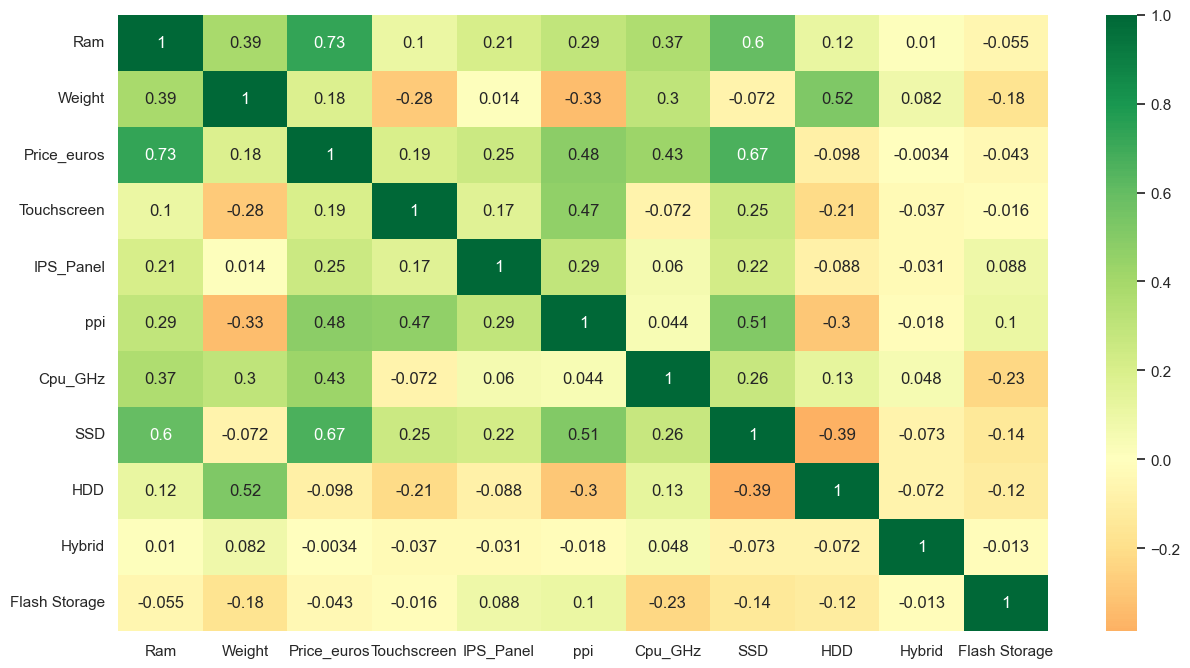

In [67]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.heatmap(df.corr(numeric_only=True), cmap='RdYlGn', center=0, annot=True)

In [69]:
# sns.pairplot(df,y_vars = 'Price_euros', corner=True)

In [70]:
from sklearn.model_selection import KFold, cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=47)

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_prep, y, cv=kf, scoring='r2')
scores

array([0.81653588, 0.72436399, 0.75429388, 0.69077816, 0.77199551])

In [71]:
mean_score = np.mean(scores)
mean_score

0.7515934854952815

In [72]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Получение важности признаковa
importance = model.coef_
#importance is a list so you can plot it. 
print(importance.reshape(len(importance), 1))
# for i, importance in enumerate(importances):
#     print("Feature", i+1, "importance:", importance)

[[ 652.57203396]
 [3258.66848145]
 [  33.90071097]
 [ 856.56251488]
 [  21.7409575 ]
 [ 445.02879532]
 [ 463.98197426]
 [ 644.88029491]
 [-258.42616185]
 [ 379.45194941]
 [-172.18157495]
 [-437.74122937]
 [-148.24759444]
 [-239.11288684]
 [ 274.09233527]
 [ -38.03480786]
 [   0.        ]
 [ 543.37729066]
 [-115.22399641]
 [ -51.5341291 ]
 [-316.77683373]
 [  89.03602632]
 [ 764.03270422]
 [ -56.71243273]
 [  21.69516278]
 [-224.95581893]
 [ -12.73800244]
 [ -70.7074614 ]
 [-163.41493213]
 [-144.83433593]
 [-284.92643268]
 [  20.09312823]
 [ 643.7900339 ]
 [-210.10634025]
 [  15.20636212]
 [   4.8474259 ]
 [-446.17949762]
 [-125.44961894]
 [ 111.78887059]
 [ 332.71700473]
 [ 560.65832337]
 [-243.48252988]
 [ -94.76794146]
 [ 120.38967049]
 [ -25.62172903]
 [ -44.9335368 ]
 [ -25.62172903]
 [  55.80680414]
 [  14.74846169]]


In [ ]:
X = processor.transform(X)
model = LinearRegression()
# model = Ridge(alpha=0.5)
model.fit(X, y)

Ridge(alpha=0.5)

In [74]:
test1 = test_data.copy()
test1 = preprocessing(test1)
test1

,Company,TypeName,Ram,OpSys,Weight,Touchscreen,IPS_Panel,ppi,Cpu_GHz,Cpu_Company,SSD,HDD,Hybrid,Flash Storage,Gpu_Company,Gpu_model
0,Acer,Notebook,4,Windows 10,2.10,0,0,100.454670,3.0,AMD,0,1024,0,0,AMD,Radeon
1,Razer,Gaming,16,Windows 10,1.95,0,0,157.350512,2.8,Intel,1024,0,0,0,Nvidia,GeForce GTX
2,Asus,Notebook,8,Windows 10,1.70,0,0,141.211998,1.8,Intel,256,0,0,0,Nvidia,GeForce
3,Asus,Gaming,16,Windows 10,2.99,0,0,127.335675,2.8,Intel,256,1024,0,0,Nvidia,Other
4,Dell,Notebook,12,Windows 10,2.25,0,0,100.454670,2.5,Intel,0,1024,0,0,Intel,HD Graphics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,HP,Notebook,4,Windows 10,2.07,0,0,141.211998,2.3,Intel,0,500,0,0,Intel,HD Graphics
191,Acer,Notebook,8,Windows 10,2.20,0,1,141.211998,1.8,Intel,0,1024,0,0,Nvidia,GeForce
192,HP,Ultrabook,8,Windows 10,1.32,0,1,165.632118,2.7,Intel,256,0,0,0,Intel,HD Graphics
193,Dell,2 in 1 Convertible,16,Windows 10,2.09,1,0,141.211998,2.7,Intel,512,0,0,0,Intel,HD Graphics


In [75]:

test1 = processor.transform(test1)

pred = model.predict(test1)
submission = pd.DataFrame({'index': test_data.index, 'Price_euros': pred})
submission.to_csv('submission.csv', index=False)

In [76]:
# lst = np.arange(0.1, 1, 0.01)
# minMAE = 10000
# minMSE = minMAE*minMAE
# maxR2 = 0
# minI_MSE = 1
# minI_MAE = 1
# maxI_R2 = 0
# for i in lst:
#     X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=i, random_state=47)

#     model = LinearRegression()
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     if minMAE > metrics.mean_absolute_error(y_test, y_pred):
#         minMAE = metrics.mean_absolute_error(y_test, y_pred)
#         minI_MSE = i

#     if minMSE > metrics.mean_squared_error(y_test, y_pred):
#         minMSE = metrics.mean_squared_error(y_test, y_pred)
#         minI_MAE = i

#     if maxR2 < model.score(X_test, y_test):
#         maxR2 = model.score(X_test, y_test)
#         maxI_R2 = i

# print("MAE", minMAE)
# print("MAE", minI_MAE)
# print("MSE", minMSE)
# print("MSE", minI_MSE)
# print("R2 Score:", maxR2)
# print("R2 Score:", maxI_R2)